In [2]:
import pandas as pd
import numpy as np

import scipy.sparse
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import mean_squared_error, mean_absolute_error, precision_score, recall_score, f1_score

# Your code here

from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
import nltk
import re
import string

# Ensure to download required NLTK data
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# Sample DataFrame
data = pd.read_csv('/content/Womens Clothing E-Commerce Reviews new.csv')  # Load your dataset

# Convert the date column to datetime
data['Date'] = pd.to_datetime(data['Date'], errors='coerce')

# Define stopwords and initialize lemmatizer
stop_words = set(stopwords.words('english'))
additional_stop_words = {'wa', 'ha', 'dress', 'fit', 'size', 'color', 'fabric', 'material', 'pattern', 'print', 'style', 'design', 'look', 'feel', 'wear', 'comfortable', 'uncomfortable', 'beautiful', 'pretty', 'nice', 'lovely', 'awesome', 'good', 'great', 'perfect', 'amazing', 'excellent', 'love', 'like', 'dislike', 'hate', 'buy', 'purchase', 'order', 'return', 'exchange', 'recommend', 'recommendation', 'star', 'rating'}
stop_words = stop_words.union(additional_stop_words)
lemmatizer = WordNetLemmatizer()

# Function for text preprocessing
def preprocess_text(text):
    if isinstance(text, str):  # Check if the input is a string
        # Tokenization and lowercase conversion
        tokens = word_tokenize(text.lower())
        # Remove punctuation, stopwords, short tokens, tokens with digits
        tokens = [token for token in tokens if token not in string.punctuation and token not in stop_words and len(token) > 2 and not re.search(r'\d', token)]
        # Lemmatization
        tokens = [lemmatizer.lemmatize(token) for token in tokens]
        return ' '.join(tokens)
    else:
        return ""  # Return an empty string for non-string inputs

# Apply preprocessing to 'Review Text' column
data['Processed_Review'] = data['Review Text'].apply(preprocess_text)

# TF-IDF Vectorization
vectorizer = TfidfVectorizer(max_features=1000)  # Adjust max_features as needed
X_tfidf = vectorizer.fit_transform(data['Processed_Review'])

# Get feature names (keywords)
feature_names = vectorizer.get_feature_names_out()

# Define numerical features and standardize them
numerical_features = ['Age', 'Rating', 'Positive Feedback Count']
scaler = StandardScaler()
data[numerical_features] = scaler.fit_transform(data[numerical_features])

# Combine TF-IDF features with other numerical features
X_numerical = data[numerical_features].values
X = scipy.sparse.hstack([X_tfidf, X_numerical])

# Define target variable
y = data['Recommended IND']

# Ensure the 'Class Name' column is categorical
data['Class Name'] = data['Class Name'].astype('category')

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Assume 'data' is your DataFrame with a 'Date' column
data = data.sort_values(by='Date')

# Prepare data for LSTM model
X_data = X.todense()
y_data = y.values

# Split data into train and test sets
train_size = int(len(X_data) * 0.8)
X_train, X_test = X_data[:train_size], X_data[train_size:]
y_train, y_test = y_data[:train_size], y_data[train_size:]

# Reshape data for LSTM input
X_train = np.array(X_train).reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = np.array(X_test).reshape((X_test.shape[0], 1, X_test.shape[1]))

# Build LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(1, X_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)

# Predict using the trained model
y_pred_lstm = model.predict(X_test)

from collections import defaultdict
import numpy as np

# Example outputs
trending_attributes = defaultdict(list)
recommendation_rates = {}
time_based_trends = defaultdict(list)
predictive_insights = {}

# Identify trending attributes
for class_name in data['Class Name'].unique():
    class_data = data[data['Class Name'] == class_name]
    if not class_data['Processed_Review'].str.strip().eq('').all():
        vectorizer = TfidfVectorizer(max_features=10)  # Adjust max_features as needed
        X_class = vectorizer.fit_transform(class_data['Processed_Review'])
        trending_attributes[class_name] = vectorizer.get_feature_names_out()
    else:
        trending_attributes[class_name] = ['No significant terms']

# Calculate recommendation rates
for class_name in data['Class Name'].unique():
    class_data = data[data['Class Name'] == class_name]
    if len(class_data) > 0:
        recommendation_rate = class_data['Recommended IND'].mean()
        recommendation_rates[class_name] = recommendation_rate * 100

# Calculate time-based trends
data['Month'] = data['Date'].dt.month
monthly_trends = data.groupby('Month')['Recommended IND'].mean()

for month, rate in monthly_trends.items():
    time_based_trends[month] = rate * 100

# Generate predictive insights
for i in range(len(X_test)):
    review_text = data['Review Text'].iloc[train_size + i]
    recommendation_rate = y_pred_lstm[i][0] * 100
    predictive_insights[f'Product {i + 1}'] = {
        'Predicted Recommendation Rate': recommendation_rate,
        'Review Text': review_text
    }

# Write results to a file
with open('results.txt', 'w') as f:
    f.write("Trending Attributes:\n")
    for class_name, attributes in trending_attributes.items():
        f.write(f"{class_name}: {attributes}\n")

    f.write("\nRecommendation Rates:\n")
    for class_name, rate in recommendation_rates.items():
        f.write(f"{class_name}: {rate:.2f}%\n")

    f.write("\nTime-based Trends:\n")
    for month, trend in time_based_trends.items():
        f.write(f"Month: {month} shows a higher trend for recommendation rates of {trend:.2f}%.\n")

    f.write("\nPredictive Insights:\n")
    for product, details in predictive_insights.items():
        f.write(f"{product}:\n")
        f.write(f"  Predicted Recommendation Rate: {details['Predicted Recommendation Rate']:.2f}%\n")
        f.write(f"  Review Text: {details['Review Text']}\n")

# Read and print the results from the file
with open('results.txt', 'r') as f:
    print(f.read())


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
<ipython-input-2-f3c3c3bdf09d>:32: UserWarning: Parsing dates in %d-%m-%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  data['Date'] = pd.to_datetime(data['Date'], errors='coerce')


Streaming output truncated to the last 5000 lines.
Product 3127:
  Predicted Recommendation Rate: 97.85%
  Review Text: I purchased this blazer and its so comfortable. it runs small i am usually a size 6 but had to get it in size 8. i will be getting a lot of use out of this blazer. it can be worn professionally with skirt or solid color dress or casual with jeans. the fabric so very soft almost like a sweatshirt.
Product 3128:
  Predicted Recommendation Rate: 95.12%
  Review Text: Originally i bought this in black and white. recently purchased several more in different colorways . why? it's just perfect to wear as an under tank/cami. i'm a busty gal and sometimes cami straps can be too thin and dig into my shoulders. this is soft, smooth and provides just enough coverage. very flattering fit on its own as well. great under loose knit or low cut sweaters. love!
Product 3129:
  Predicted Recommendation Rate: 99.87%
  Review Text: The breast and arm area is too tight. best to size up two

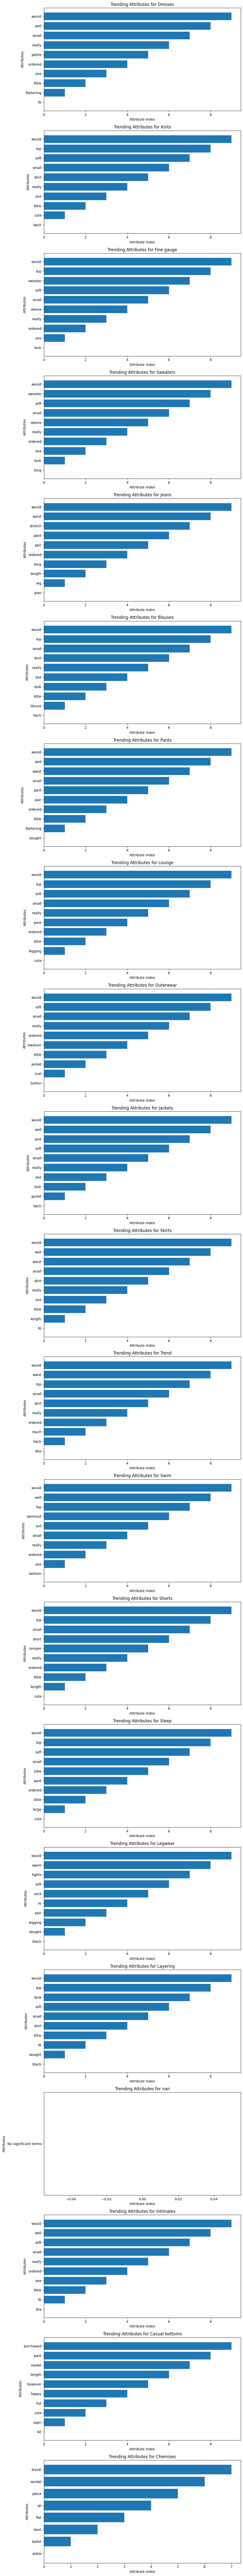

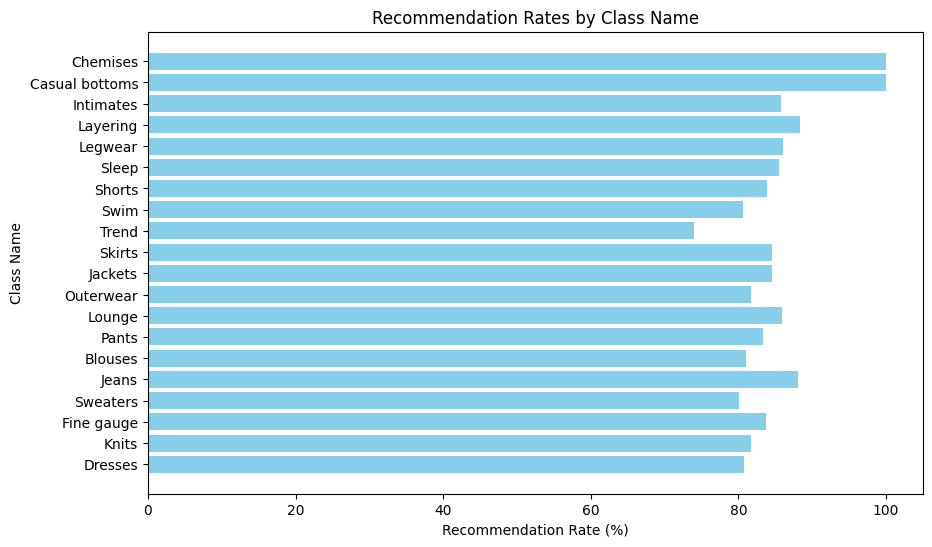

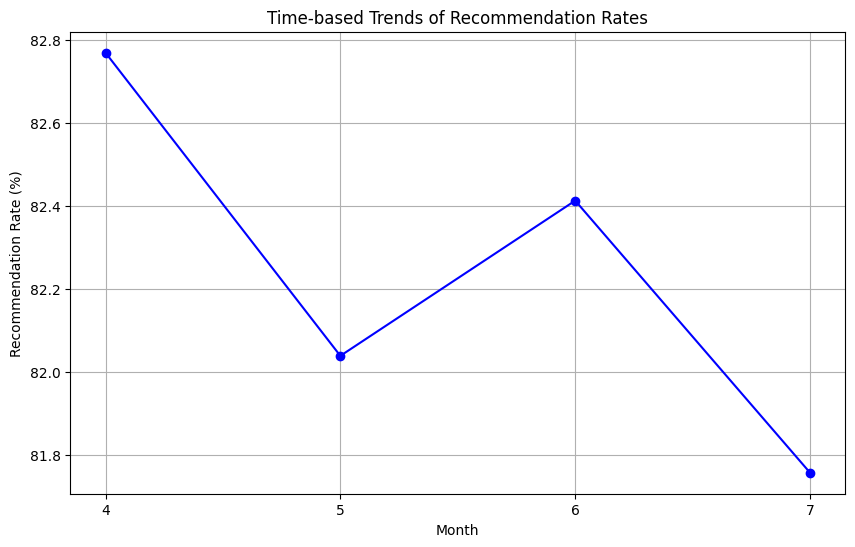

In [3]:
import matplotlib.pyplot as plt

# Plot trending attributes
def plot_trending_attributes(trending_attributes):
    fig, axes = plt.subplots(len(trending_attributes), 1, figsize=(10, 5 * len(trending_attributes)))
    if len(trending_attributes) == 1:
        axes = [axes]  # Ensure axes is iterable when there's only one subplot

    for i, (class_name, attributes) in enumerate(trending_attributes.items()):
        axes[i].barh(attributes, range(len(attributes)))
        axes[i].set_title(f"Trending Attributes for {class_name}")
        axes[i].set_xlabel("Attribute Index")
        axes[i].set_ylabel("Attributes")

    plt.tight_layout()
    plt.show()

# Plot recommendation rates
def plot_recommendation_rates(recommendation_rates):
    class_names = list(recommendation_rates.keys())
    rates = list(recommendation_rates.values())

    plt.figure(figsize=(10, 6))
    plt.barh(class_names, rates, color='skyblue')
    plt.xlabel('Recommendation Rate (%)')
    plt.ylabel('Class Name')
    plt.title('Recommendation Rates by Class Name')
    plt.show()

# Plot time-based trends
def plot_time_based_trends(time_based_trends):
    months = list(time_based_trends.keys())
    trends = list(time_based_trends.values())

    plt.figure(figsize=(10, 6))
    plt.plot(months, trends, marker='o', linestyle='-', color='b')
    plt.xlabel('Month')
    plt.ylabel('Recommendation Rate (%)')
    plt.title('Time-based Trends of Recommendation Rates')
    plt.xticks(months)  # Ensure all months are shown on x-axis
    plt.grid(True)
    plt.show()

# Call plotting functions
plot_trending_attributes(trending_attributes)
plot_recommendation_rates(recommendation_rates)
plot_time_based_trends(time_based_trends)
